In [119]:
import numpy as np
import torch

%run maze_generation.ipynb import *

(8, 8)


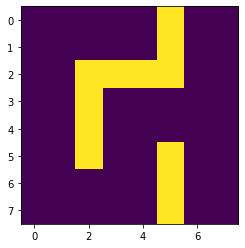

In [226]:
np.random.seed(1)
maze = generate_wide_maze(3,2)
plt.imshow(maze)
print(maze.shape)

In [227]:
"""
NODE SELECTION
    A differentiable operation designed to select the lowest cost node.
    
    input:
        o (1d Tensor): 1d Tensor indicating status of node within the openset
        g (1d Tensor): 1d Tensor indicating the g-score associated to a node
        h (1d Tensor): 1d Tensor indicating estimated costs of reaching each node
    output:
        (int): index of the lowest cost node in the flattened tensor
"""
def node_selection(o,g,h):
    tau = 5
    v_star = (np.exp(-(g.flatten() + h.flatten())/tau) * o.flatten()) / \
                    (np.exp(-(g.flatten() + h.flatten())/tau) @ o.T.flatten())
    return v_star.flatten().argmax()

o = torch.Tensor(np.random.randint(0,2,len(maze)**2).reshape((len(maze),len(maze))))
g = torch.Tensor(np.random.rand(len(maze)**2).reshape((len(maze),len(maze))))
h = torch.Tensor(np.random.rand(len(maze)**2).reshape((len(maze),len(maze))))
o.flatten()[27] = 1
g.flatten()[27] = 0
h.flatten()[27] = 0
v_star = node_selection(o,g,h)
v_star

tensor(27)

In [238]:
"""
NODE EXPANSION
    Expand the search to include the nodes that are neighbours to a given node.
"""
def node_expansion(v_star, cells, o, c):
    # Create the kernel
    K = torch.Tensor([[[[1,1,1],[1,0,1],[1,1,1]]]])
    
    # Get the indicator vector from the 
    v_star_I = torch.zeros(len(maze), len(maze))
    v_star_I.flatten()[v_star] = 1

    # Perform the convolution
    neighbours = torch.nn.functional.conv2d(v_star_I.reshape((1,1,len(maze),len(maze))), K, padding=1)
    
    # Exclude walls, and elements in the closed set:
    neighbours = neighbours * (1 - cells) * (1 - o) * (1 - c)
    return neighbours

v_star_I = torch.zeros(len(maze), len(maze))
v_star_I.flatten()[v_star] = 1
    
o = torch.zeros(maze.shape)    
c = o = torch.zeros(maze.shape)
    
print("v_star",v_star)    
print("maze\n",maze)
print("v_star_I\n",v_star_I)
neighbours = node_expansion(v_star, maze, o, c)
print("node expansion\n",neighbours)

v_star tensor(27)
maze
 [[0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 1 1 1 1 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0 0]]
v_star_I
 tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
node expansion
 tensor([[[[0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 1., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]], dtype=torch.float64)


In [ ]:
"""
UPDATING GUIDANCE COSTS: G
"""

In [195]:
v_star_I.reshape((1,1,15,15))

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [182]:

K

tensor([[[[1., 1., 1.],
          [1., 0., 1.],
          [1., 1., 1.]]]])

In [196]:
torch.nn.functional.conv2d(v_star_I.reshape((1,1,len(maze),len(maze))), K)

tensor([[[[0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [177]:
torch.nn.functional.conv2d(v_star_I, 

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [15, 15]

In [525]:
normal_distance = lambda x,y : np.linalg.norm(np.array(x) - np.array(y))


def reconstruct_path(source, current):
    total_path = [current]
    while str(current) in source.keys():
        current = source[str(current)]
        total_path = [current] + total_path
    return total_path

def neural_a_star(cells, start=(1,1), end=(-2,-2), h = normal_distance, diagonals = False):
    MAZE_SIZE = len(cells)
    
    openset = np.zeros(MAZE_SIZE ** 2)
    closedset = np.zeros(MAZE_SIZE ** 2)
    source = np.zeros(MAZE_SIZE ** 2)

    gscore = np.full(MAZE_SIZE ** 2, np.inf)
    fscore = np.full(MAZE_SIZE ** 2, np.inf)

    start = t2o(MAZE_SIZE, start)
    end = t2o(MAZE_SIZE, end)
    
    openset[start] = 1
    gscore[start] = 0
    fscore[start] = h(start, end)
    
    while np.any(openset):
                
        # Get the lowest f-score in the open-set
        current = np.where(fscore == np.min(fscore))[0]
        openset[current] = 0
        closedset[current] = 1
        
        print(f"openset {np.sum(openset)} // closedset {np.sum(closedset)} // current {current}")
        
        # If we're at the goal, reconstruct our path and return it
        print(current, end)
        if current == end:
            print("End")
            return reconstruct_path(source, current)
        
        # Check each neighbouring cell and update the f/g scores
        if diagonals == True:
            neighbours = [0,0.5,1,1.5,2,2.5,3]
        else:
            neighbours = [0,1,2,3]
            
        neighbours = [np.array(np.round([np.sin(direction * np.pi / 2), np.cos(direction * np.pi / 2)]), dtype=int) 
                           + o2t(MAZE_SIZE, current) for direction in neighbours]
        
        print(neighbours, "curr", current, 'o2t curr', o2t(MAZE_SIZE, current))
        
        for neighbour in neighbours:
            neighbour = tuple(neighbour)
            print("neighbour", neighbour)
            # Ensure the neighbour is within bounds and is not a wall
            if neighbour[0] >= MAZE_SIZE or neighbour[0] < 0 \
                    or neighbour[1] >= MAZE_SIZE or neighbour[1] < 0 \
                    or cells[neighbour] != 0 \
                    or closedset[t2o(MAZE_SIZE, neighbour)] == 1: continue
                
            tentative_gscore = gscore[current] + 1
            
            neighbour = t2o(MAZE_SIZE, neighbour)
            print("neighbour2", neighbour)
            
            if tentative_gscore <= gscore[neighbour]:
                source[neighbour] = current
                gscore[neighbour] = tentative_gscore
                fscore[neighbour] = tentative_gscore + h(neighbour, end)

                if openset[neighbour] == 0:
                    openset[neighbour] = 1
                    
    return source, gscore, fscore

MAZE_SIZE =  19


NameError: name 'neural_a_star' is not defined

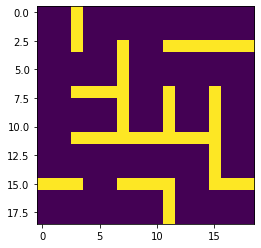

In [522]:
a = (0,1)
a[0] = 1

TypeError: 'tuple' object does not support item assignment

In [424]:
maze.shape

(19, 19)

In [366]:
v_star = (np.exp(-(g + h)/tau) * o) / (np.exp(-(g + h)/tau) @ o.T)
res = np.where(v_star == np.max(v_star))
v_star, res

(array([0.01976358, 0.        , 0.03871644, 0.04884302, 0.        ,
        0.26777215, 0.05812617, 0.21286082, 0.        , 0.        ,
        0.02119404, 0.        , 0.        , 0.02578841, 0.        ,
        0.16360934, 0.        , 0.        , 0.01356245, 0.02473344,
        0.01129996, 0.        , 0.05448335, 0.        , 0.03924684]),
 (array([5], dtype=int64),))

In [367]:
o, g, h

(array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
        1, 0, 1]),
 array([9.88617946, 5.27685573, 6.10771796, 3.29000053, 2.26068109,
        0.42117772, 5.35401447, 1.        , 2.6421589 , 0.89768528,
        9.18189539, 4.89151028, 8.20695147, 4.73121819, 5.97606969,
        3.22037494, 4.00646982, 7.89122021, 6.98690732, 9.71420307,
        8.1939698 , 7.95399589, 0.42722553, 2.47754742, 4.35049796]),
 array([3.99780999, 8.67458401, 4.41415327, 6.07013496, 9.52486934,
        0.43133264, 3.13609817, 1.        , 6.39282116, 0.76344943,
        4.35269811, 2.67311549, 8.92174924, 7.8223477 , 6.01661128,
        0.09541007, 1.97523319, 1.78583582, 8.77976061, 3.04820832,
        8.48522501, 7.96689503, 8.38649144, 2.99963357, 6.10333954]))

In [271]:
numer = np.exp(-(g+h)/tau) * o
numer

array([[0.        , 0.84707385, 0.        , 0.74817963, 0.        ],
       [0.        , 0.        , 0.        , 0.72976068, 0.92478338],
       [0.79926324, 0.        , 0.        , 0.        , 0.80891841],
       [0.74038291, 0.        , 0.30119421, 0.        , 0.87998011],
       [0.87594847, 0.91958669, 0.92200382, 0.76634524, 0.77446267]])

In [272]:
denom = np.exp(-(g+h)/tau) @ o.T
denom

array([[1.59525348, 1.67553764, 1.82999918, 2.64925667, 4.24451014],
       [1.53323137, 1.65454405, 1.75762545, 2.68305632, 4.21628769],
       [1.61042342, 1.5711941 , 1.60818165, 2.34227121, 3.95269463],
       [1.66495082, 1.60692582, 1.62036302, 1.92155723, 3.58650805],
       [1.68593193, 1.54080792, 1.65041115, 2.57241497, 4.2583469 ]])

In [273]:
numer/denom

array([[0.        , 0.50555346, 0.        , 0.28241115, 0.        ],
       [0.        , 0.        , 0.        , 0.27198858, 0.21933593],
       [0.49630627, 0.        , 0.        , 0.        , 0.20464986],
       [0.44468756, 0.        , 0.1858807 , 0.        , 0.24535847],
       [0.51956337, 0.59682111, 0.55865099, 0.29790887, 0.18186932]])

In [268]:
np.divide(numer, denom)

array([[0.        , 0.35823491, 0.        , 0.5398286 , 0.23409502],
       [0.30776496, 0.        , 0.39468965, 0.        , 0.24720273],
       [0.        , 0.31407696, 0.        , 0.42113881, 0.2916167 ],
       [0.        , 0.        , 0.41313911, 0.        , 0.22693705],
       [0.30077245, 0.37116372, 0.34233428, 0.54330736, 0.        ]])

In [274]:
np.inner(np.exp(-(g+h)/tau), o)



array([[1.59525348, 1.67553764, 1.82999918, 2.64925667, 4.24451014],
       [1.53323137, 1.65454405, 1.75762545, 2.68305632, 4.21628769],
       [1.61042342, 1.5711941 , 1.60818165, 2.34227121, 3.95269463],
       [1.66495082, 1.60692582, 1.62036302, 1.92155723, 3.58650805],
       [1.68593193, 1.54080792, 1.65041115, 2.57241497, 4.2583469 ]])

In [ ]:
np.exp(-(g+h)/tau)